In [1]:
import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from DataLoader import data_loader
import torchvision.transforms as transforms
from SegNet import SegNet

In [2]:
pwd

'/datasets/home/14/214/c6du/ECE 285/Project/0519'

In [3]:
def data_loader(index, root, mode, Transform_data, Transform_lbl, ctg_index):
    from PIL import Image
    import PIL
    def Categories(input_image, input_list):
        input_list.sort()
        C = len(input_list)
        input_image = np.array(input_image)
        target = np.zeros((input_image.shape[0], input_image.shape[1]))

        for i in range(C):
            target[np.where(input_image == input_list[i])] = i
        target = np.array(target)
        
        return Image.fromarray(np.uint8(target))


    image_path0 = root + mode + '/' + mode + '_'
    
    for idx in index:
        
        # Read data
        data_path = image_path0 + '{0:05d}'.format(idx) + '_ori.png'
        lbl_path  = image_path0 + '{0:05d}'.format(idx) + '_lbl.png'
        data_idx = Image.open(data_path)
        lbl_idx  = Image.open(lbl_path)

        # Calculate categories of label image
        lbl_idx = Categories(lbl_idx, ctg_index)

        # Apply Resize, ToTensor, Normalization
        data_out = Transform_data(data_idx)
        lbl_out = Transform_lbl(lbl_idx)
        lbl_out = np.array(lbl_out)
        lbl_out = torch.from_numpy(lbl_out)
        
        # Add dimension
        data_out.unsqueeze_(0)
        lbl_out.unsqueeze_(0)
        yield data_out, lbl_out.long()
        
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)


In [4]:
def output_show(train_ori, train_lbl,output):
    import matplotlib.pyplot as plt
    img = train_ori.cpu().squeeze(0).permute(1,2,0).numpy()
    
    plt.figure(figsize= (5.4,4))
    plt.imshow(img)
    plt.title('train_ori')
    plt.show()
    
    img = train_lbl.cpu().squeeze(0).numpy()
    
    plt.figure(figsize= (5.4,4))
    plt.imshow(img)
    plt.title('train_lbl')
    plt.show()
    
    img = torch.argmax(output.cpu(), dim = 1)
    img = img.squeeze(0).numpy()

    plt.figure(figsize= (5.4,4))
    plt.title('output')
    plt.imshow(img)
    plt.show()

# Training

In [7]:
# Hyprt Parameter
num_image = 2975  # Size of dataset
index = np.arange(num_image).tolist()
np.random.shuffle(index) # Shuffle data
root = '/datasets/home/14/214/c6du/data/Cityscape_modified/' # Root path
mode = 'train' # train, test, valid
output_size = (450, 900)  # (height, width)

Transform_data = transforms.Compose([transforms.Resize(output_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])
Transform_lbl  = transforms.Compose([transforms.Resize(output_size),
                                    ])
### First epoch / read file checkpoint_with_epoch_00000_Adam.pth.tar
load_file = True
load_file_optim = 'Adam'
load_file_epoch = 0
load_file_name = 'checkpoint_with_epoch_{0:05d}'.format(load_file_epoch) +\
        '_' + load_file_optim + '.pth.tar'




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device)

class_num = [0, 7, 11, 26, 24]
net = SegNet(class_num = len(class_num), img_size = output_size)
net = net.to(device)
lrinit = 0.0001

optim_model = 'Adam' # 'SGD', 'Adagrad', 'RMSprop' 
lr_change = True

if optim_model == 'Adam':
    optimizer = torch.optim.Adam(net.parameters(), lr = lrinit)
    model_type = optim_model + '_lrinit=' + str(lrinit).split('.')[-1] + \
    '_lrchange=' + str(lr_change)
    print('optimizer:', model_type)
    
else:
    raise Exception('Optimizer not supported!')
    
criteria = nn.CrossEntropyLoss()


device: cuda:0
optimizer: Adam_lrinit=0001_lrchange=True


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


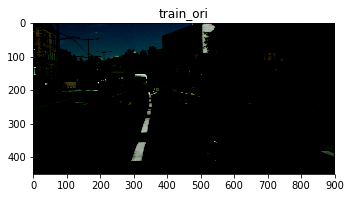

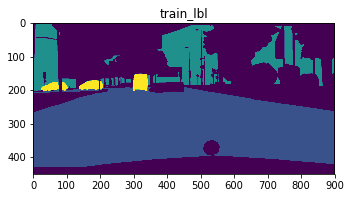

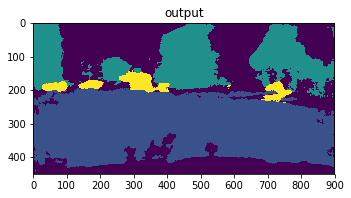

KeyboardInterrupt: 

In [8]:
from tqdm import tqdm_notebook as tqdm
import os

loss_list = []
epoch_m = 10
learn_r = lrinit
if not load_file:
    for epoch in tqdm(range(epoch_m)):

        np.random.shuffle(index) # Shuffle data
        train_loader = data_loader(index, root, mode, Transform_data, Transform_lbl, class_num)

        for counter, elements in tqdm(enumerate(train_loader)):
            train_img = elements[0].to(device)
            train_lbl = elements[1].to(device)
            output = net(train_img)
            loss = criteria(output, train_lbl)
            loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if counter % 100 == 0:
                output_show(train_img,train_lbl, output)

        if lr_change == True:

            if optim_model == 'Adam':
                learn_r = lrinit / 2 ** epoch
                print('lr = ' + str(learn_r))
                optimizer = torch.optim.Adam(net.parameters(), lr = learn_r)

        save_file_name = 'checkpoint_with_epoch_{0:05d}'.format(epoch) +\
        '_' + optim_model + '.pth.tar'
        print(save_file_name)
        save_checkpoint({'epoch': epoch,
                         'net_dict': net.state_dict(),
                         'learn_r': learn_r,
                         'optim_model': optim_model,
                         'loss_list': loss_list},
                        filename = './' + save_file_name) 

else:
    
    checkpoint = torch.load(load_file_name)
    epoch_s = checkpoint['epoch'] + 1
    net.load_state_dict(checkpoint['net_dict'])
    learn_r = checkpoint['learn_r']
    optim_model = checkpoint['optim_model']
    loss_list = checkpoint['loss_list']
    
    for epoch in tqdm(range(epoch_s, epoch_s + epoch_m)):

        np.random.shuffle(index) # Shuffle data
        train_loader = data_loader(index, root, mode, Transform_data, Transform_lbl, class_num)

        for counter, elements in tqdm(enumerate(train_loader)):
            train_img = elements[0].to(device)
            train_lbl = elements[1].to(device)
            output = net(train_img)
            loss = criteria(output, train_lbl)
            loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if counter % 100 == 0:
                output_show(train_img,train_lbl, output)

        if lr_change == True:

            if optim_model == 'Adam':
                learn_r = lrinit / 2 ** epoch
                print('lr = ' + str(learn_r))
                optimizer = torch.optim.Adam(net.parameters(), lr = learn_r)
                
        save_file_name = 'checkpoint_with_epoch_{0:05d}'.format(epoch) +\
        '_' + optim_model + '.pth.tar'
        print(save_file_name)
        save_checkpoint({'epoch': epoch,
                         'net_dict': net.state_dict(),
                         'learn_r': learn_r,
                         'optim_model': optim_model,
                         'loss_list': loss_list},
                        filename = './' + save_file_name)


In [ ]:
plt.plot(loss_list)

In [27]:
pwd

'/datasets/home/14/214/c6du/ECE 285/Project/0519'